# Welcome back guys!
In this opportunity you will learn how to:
1. Use an irregular shaped seismic in Segysak.
2. Plot a horizon as a 2D map.
3. Import seismic attributes.
4. Predict facies from seismic attributes with SOM (Self Organizing Maps).
5. Display the prediction on a seismic horizon.
6. Plot a line inside the horizon and the horizon inside a specific line. 

In [1]:
from segysak.segy import segy_loader

seismic = segy_loader('subcube2.sgy',
                      iline=189, xline=193, cdpx=181, cdpy=185,
                      vert_domain="TWT"
                     )
seismic

D:\ANACONDA\lib\site-packages\segysak\segy\_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



Loading as 3D
Fast direction is CROSSLINE_3D


<xarray.Dataset>
Dimensions:  (iline: 646, xline: 619, twt: 227)
Coordinates:
  * iline    (iline) int64 52 53 54 55 56 57 58 ... 691 692 693 694 695 696 697
  * xline    (xline) int64 44 45 46 47 48 49 50 ... 656 657 658 659 660 661 662
  * twt      (twt) float64 848.0 850.0 852.0 ... 1.296e+03 1.298e+03 1.3e+03
    cdp_x    (iline, xline) float64 nan 4.847e+05 4.847e+05 ... nan nan nan
    cdp_y    (iline, xline) float64 nan 9.815e+05 9.815e+05 ... nan nan nan
Data variables:
    data     (iline, xline, twt) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/13)
    ns:                  None
    sample_rate:         2.0
    text:                C01  Created by: OpendTect     (dom. 14 nov. 2021, 1...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         subcube2.sgy
    srd:                 None
    datatype:            None
    percentiles:         [-70.3698133264466, -70.31014311892811, -39.23813528...
    coord_scalar:        -10.0

In [2]:
import numpy as np

ma = np.percentile(seismic['data'], 99.95)

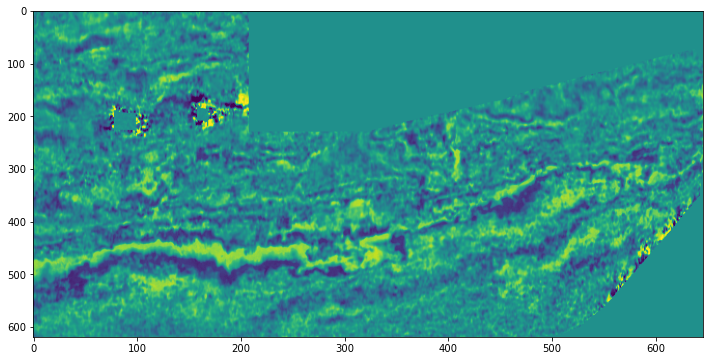

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(seismic['data'][:, :, 100].T, aspect='auto', vmin=-ma, vmax=ma)

### Load horizon

In [4]:
import pandas as pd

names = ["iline", "xline", "twt",
         'Amplitud','firstDeri','secondDeri',
         'Fase','Frecuencia_Dominante','F_50','F_40','F_15',
          'Hilbert','Qfactor','Thinbed']

df = pd.read_csv('h_Attributes_2', names=names, sep="\s+")

df = df.set_index(["iline", "xline"])  # <-- This step is important.

df.head()

twt   Amplitud   firstDeri  secondDeri      Fase  \
iline xline                                                             
52    45     1278.331518  16.238707  -48.017021   61630.832 -0.104739   
      46     1279.500961  15.189196 -270.850890   36286.949 -0.086320   
      47     1281.668305  16.965900   67.251205  -53554.648  0.024015   
      48     1282.426834  19.155159   89.539520   89673.515 -0.018696   
      49     1283.501506  23.068329  117.047780  -91621.984  0.042936   

             Frecuencia_Dominante       F_50       F_40       F_15   Hilbert  \
iline xline                                                                    
52    45                33.795681  139.93615  201.41929  128.31869 -1.697719   
      46                33.333336  114.03424  186.25914  136.80632 -1.309505   
      47                33.333000  111.01498  206.15461  163.07566  0.407389   
      48                33.332989  134.25262  242.73214  185.49649 -0.358104   
      49                33.333302  159.70037  277.08111  206.41378  0.990161   

                Qfactor   Thinbed  
iline xline                        
52    45    -188.207740 -6.591049  
      46     -30.037619 -2.321213  
      47    -129.673570  4.396423  
      48    -104.044860 -3.428619  
      49    -105.611410  2.096237

### Let's take a look

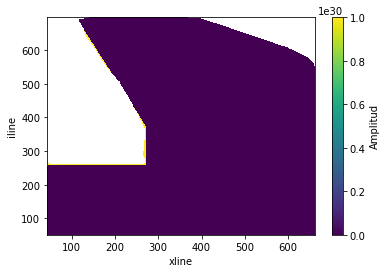

In [5]:
import xarray as xr

amp = xr.DataArray.from_series(df['Amplitud'])
amp.plot()

### There are some very large values in here, let's check them:

In [6]:
amp.sel(iline=300, xline=slice(250, 280))

<xarray.DataArray 'Amplitud' (xline: 31)>
array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan, 1.0000000e+30, 1.0000000e+30,
       1.0000000e+30, 1.0000000e+30, 1.0000000e+30, 1.0000000e+30,
       3.7157841e+01, 5.0386402e+01, 5.5121803e+01, 5.0523319e+01,
       3.9729290e+01, 2.8653376e+01, 2.5163456e+01])
Coordinates:
    iline    int64 300
  * xline    (xline) int64 250 251 252 253 254 255 ... 275 276 277 278 279 280

### We'll have to deal with these bad values and plot it again.

In [7]:
df = df.loc[df['Amplitud'] < 1e3]

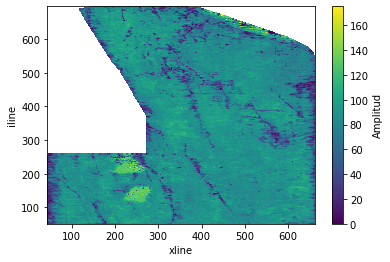

In [8]:
amp = xr.DataArray.from_series(df['Amplitud'])
amp.plot()

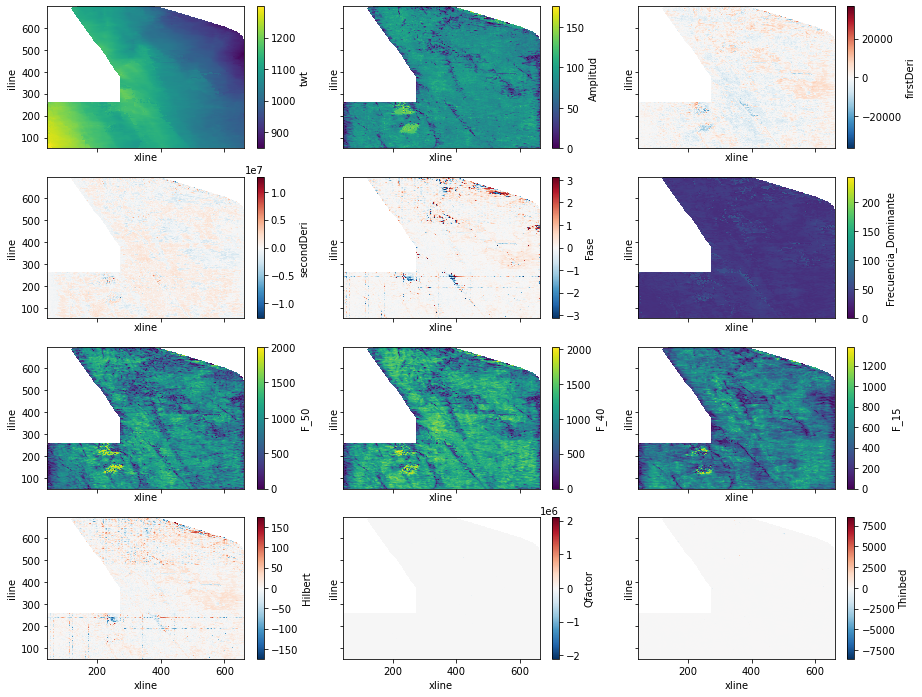

In [9]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12), sharey=True, sharex=True)
for ax, col in zip(axs.flat, df.columns):
    hor = xr.DataArray.from_series(df[col])
    hor.plot.imshow(ax=ax)

### Now, let's prepare the dataset for the SOM

In [10]:
features = [
'Amplitud','firstDeri','secondDeri',
         'Fase','Frecuencia_Dominante','F_50','F_40','F_15',
          'Hilbert','Qfactor','Thinbed'
]

X = df.loc[:, features].values

### Preprocess

In [11]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

### SOM

In [12]:
from sklearn_som.som import SOM

### Now, just like with any classifier right from sklearn, we will have to build an SOM instance and call .fit() on our data to fit the SOM

In [13]:
som = SOM(m=1, n=5, dim=len(features), random_state=42)
som.fit(X, epochs=1)

### Make prediction and put it in the DataFrame:

In [14]:
df['facies'] = som.predict(X)

### To xarray.DataArray

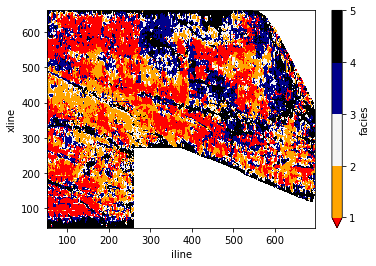

In [15]:
facies = xr.DataArray.from_series(df['facies'])
#seismic = ['firebrick','red','peachpuff','orange','whitesmoke','skyblue','darkblue','black']
seismic1 = ['red','orange','whitesmoke','darkblue','black']
facies.transpose("xline","iline").plot(levels = [1,2,3,4,5],colors = seismic1)
#facies.plot(levels=25, cmap='gist_rainbow')

### Line inside the horizon and the horizon inside a specific line

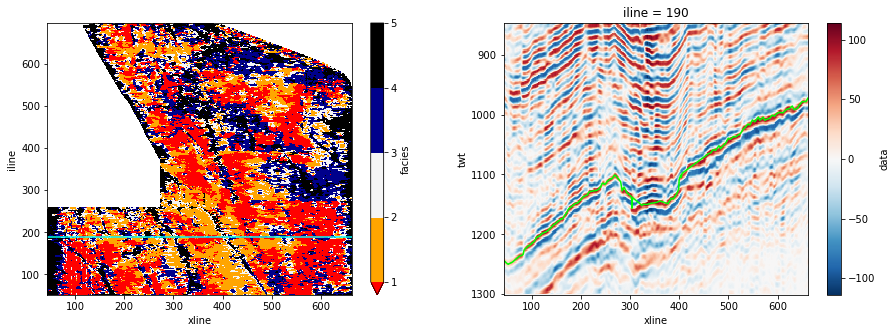

In [16]:
il = 190

twt = xr.DataArray.from_series(df['twt'])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 5))
facies.plot(ax=ax0, levels = [1,2,3,4,5],colors = seismic1)
ax0.axhline(il, c='cyan')
seismic['data'].sel(iline=il).T.plot.imshow(ax=ax1, origin='upper')
twt.sel(iline=il).plot(ax=ax1, c=(0, 1, 0))
plt.show()

### Thanks to everyone who made this research possible in Python code, but especially to Software Underground.